# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own.

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP,
you can read that data using python and preprocess that data this way only:
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients.

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2024-12-12 01:16:07--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8326901 (7.9M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.94M  22.5MB/s    in 0.4s    

2024-12-12 01:16:08 (22.5 MB/s) - ‘ita-eng.zip’ saved [8326901/8326901]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


> lets download the glove vectors ("vectors for english words"), note that this file will have vectors with 50d, 100d and 300d, you can choose any one of them based on your computing power

__ In our assignment we will be passing english text to the decoder, so we will be using these vectors in decoder embedding layer __

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2024-12-12 01:16:09--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/i486ddb1iq7mw0hatm1d7/glove.6B.100d.txt?rlkey=kpcmkp5ipzyagsw101uwcuz2e [following]
--2024-12-12 01:16:09--  https://www.dropbox.com/scl/fi/i486ddb1iq7mw0hatm1d7/glove.6B.100d.txt?rlkey=kpcmkp5ipzyagsw101uwcuz2e
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucac2a85041fe07f26785da8c200.dl.dropboxusercontent.com/cd/0/inline/CgHnTTQ-9l9nYT6f9Na65qJBpfm4m3aVi3Z1mfU9UfUBBNtRdZxt4aAGoGNP4tTr3DvHyeMl-npFgc579eo2JKLuVMJDrkZtv9cHW-T-9ZgpysVtaR2QoBe2T49zQbqJldvVnKtFx9ey3avN-SlhJM6F/file# [following]
--2024-12-12 01:16:10--  https://ucac2a85041fe07f26785da8c200.dl.dropboxusercontent.co

### <font color='blue'>**Loading data**</font>

> if you observe the data file, each feild was seprated by a tab '\t'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dot
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(377937, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 12.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 8.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
191529,siamo uscite per la colazione,<start> we went out for breakfast,we went out for breakfast <end>
348233,è un po più complicata di così,<start> it is a little more complicated than that,it is a little more complicated than that <end>
183542,io sono stato ferito da molte persone,<start> i was hurt by many people,i was hurt by many people <end>
177500,lei è la nuova assistente,<start> are you the new assistant,are you the new assistant <end>
243784,lei non sarebbe dovuto venire qui,<start> you should not have come here,you should not have come here <end>
99938,ci è voluta solamente unora,<start> it took just an hour,it took just an hour <end>
347839,gli chiederò dovè andato domenica scorsa,<start> i will ask him where he went last sunday,i will ask him where he went last sunday <end>
213935,hai fatto i tuoi compiti,<start> have you done your homework,have you done your homework <end>
249065,pensavo che tom potesse conoscere mary,<start> i thought tom might know mary,i thought tom might know mary <end>
216812,io devo rinnovare il mio passaporto,<start> i need to renew my passport,i need to renew my passport <end>


### Teacher Forcing
<pre>
Let us consider the example data point

italian: erano occupate
english_inp: &lt;start> they were busy
                |     |     |    |
english_out:  they   were busy &lt;end>

if you observe the sentences, the start token is getting mapped to the first word in your english sentence, the first word is mapped to 2nd word, the 2nd word mapped to 3rd word and so on, finall the last one will is mapped to end token. i.e i the word will be mapped to i+1th word.

As we will be passing "english_inp" as an input to the decoder and the outputs(predictions) of the decoder will be compared against the "english_out"

with this way of mapping, we can ensure that the model will predict the next word and calculate the loss accordingly.

</pre>

### Getting train and test

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(301942, 3) (75486, 3)


<ipython-input-12-4690921412cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
<ipython-input-12-4690921412cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'


In [ ]:
train.head()

,italian,english_inp,english_out
156703,noi ci stavamo solo divertendo,<start> we were just having fun,we were just having fun <end>
130376,lo so che odia la scuola,<start> i know you hate school,i know you hate school <end>
8565,io non posso fermarmi,<start> i can not stop,i can not stop <end>
272889,lavoro a boston pure io,<start> i work in boston i do too,i work in boston i do too <end>
143801,a lei piacciono i vecchi film,<start> do you enjoy old movies,do you enjoy old movies <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
335288,tom ha detto che mary mangia spesso delle banane,<start> tom said that mary often eats bananas,tom said that mary often eats bananas <end>
233819,pensavo fosse a boston,<start> i thought you were in boston,i thought you were in boston <end>
10538,loro si schiantarono,<start> they crashed,they crashed <end>
336413,avrebbe dovuto completarlo molto tempo fa,<start> you should have completed it long ago,you should have completed it long ago <end>
332926,sto solo provando ad essere un bravo vicino,<start> i am just trying to be a good neighbor,i am just trying to be a good neighbor <end>


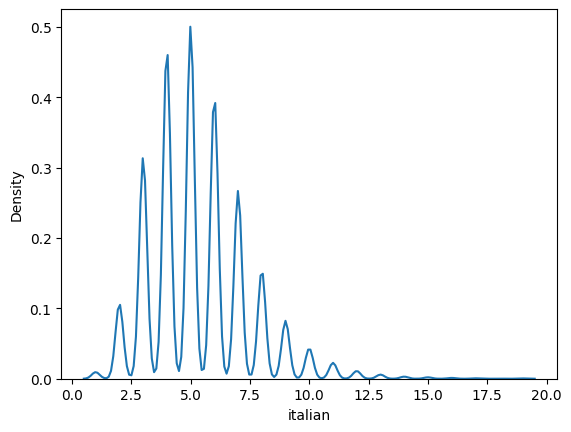

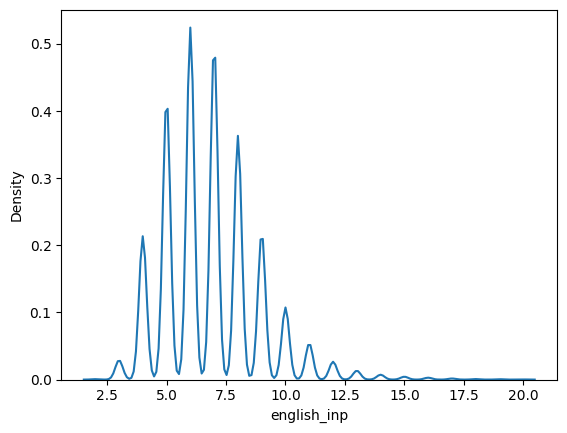

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13414
27432


In [ ]:
#tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

In [ ]:
# def grader_1(data):
#     shape_value = data.shape ==(340044, 3)
#     tknizer = Tokenizer(char_level=True)
#     tknizer.fit_on_texts(data['italian'].values)
#     ita_chars = tknizer.word_index.keys()
#     diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
#     tknizer = Tokenizer(char_level=True)
#     tknizer.fit_on_texts(data['english_inp'].values)
#     eng_chars = tknizer.word_index.keys()
#     diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
#     unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
#     return unique_char_value and shape_value

# grader_1(data)

### Creating embeddings for english sentences

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(13415, 100)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()

        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_out = 0
        self.lstm_encoder_final_state_h = 0
        self.lstm_encoder_final_state_c = 0
        self.embedding = Embedding(input_dim=self.inp_vocab_size,output_dim=self.embedding_size,input_length=self.input_length,mask_zero=True, name="embedding_layer_encoder")

        self.lstm = LSTM(self.lstm_size,return_state=True,return_sequences=True,name="Encoder_LSTM")

        #self.num_outputs = num_outputs


    def call(self,input_sequence,states):

        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedd=self.embedding(input_sequence)
        self.lstm_out,self.lstm_encoder_final_state_h,self.lstm_encoder_final_state_c=self.lstm(input_embedd)
        return self.lstm_out,self.lstm_encoder_final_state_h,self.lstm_encoder_final_state_c




    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return tf.zeros((batch_size,self.lstm_size)),tf.zeros((batch_size,self.lstm_size))



<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)

    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)

    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        super().__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length

        self.embedding=Embedding(input_dim=self.out_vocab_size,output_dim=self.embedding_size,input_length=self.input_length,mask_zero=True,name="embedding_layer_encoder")
        self.lstm=LSTM(self.lstm_size,return_sequences=True,return_state=True,name="Encoder_LSTM")



    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm

          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        input_embedd=self.embedding(input_sequence)
        decoder_out,decoder_final_state_c,decoder_final_state_h =self.lstm(input_embedd)
        return decoder_out,decoder_final_state_c,decoder_final_state_h
        #self.lstm_out,self.lstm_encoder_final_state_h,self.lstm_encoder_final_state_c=self.lstm(input_embedd)
        #return self.lstm_out,self.lstm_encoder_final_state_h,self.lstm_encoder_final_state_c




italicized text<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size


    '''
    out_vocab_size=13
    embedding_dim=12
    input_length=10
    dec_units=16
    batch_size=32

    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self,encoder_inputs_length=20,decoder_inputs_length=20,inp_vocab_size=vocab_size_ita, out_vocab_size=vocab_size_eng,lstm_size=128):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita + 1, embedding_size=50, input_length=encoder_inputs_length,lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng + 1, embedding_size=100, input_length=decoder_inputs_length,lstm_size=256)
        self.dense   = Dense(out_vocab_size, activation='softmax')



    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer

        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        initial_state = self.encoder.initialize_states(len(input))
        encoder_output, encoder_h, encoder_c = self.encoder(input,initial_state)
        decoder_output ,__,__                      = self.decoder(output,initial_states=[ encoder_h, encoder_c])
        output                               = self.dense(decoder_output)
        return output



In [ ]:
#Create an object of encoder_decoder Model class,
# Compile the model and fit the model


In [ ]:
import datetime

### Model training 1

Simple encoder decoder model

Without Attention model

In [ ]:
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)
model  = Encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,inp_vocab_size=vocab_size_ita,
                         out_vocab_size=vocab_size_eng,lstm_size=128)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit_generator(train_dataloader,
                    steps_per_epoch=train_steps, epochs=30,
                    validation_data=test_dataloader,
                    validation_steps=valid_steps,callbacks=[tensorboard])
model.summary()

AttributeError: 'Encoder_decoder' object has no attribute 'fit_generator'

In [ ]:
!kill 426

In [ ]:
from IPython.display import Image
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM
from tensorflow.keras.models import Model
import numpy as np

In [ ]:
# This function predict Translated sentence and return Translated sentence and attention weights
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences(encoder_seq,maxlen=20,dtype='int32',padding='post')
  initial_state=model.layers[0].initialize_states(1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](encoder_seq,initial_state)
  states_values = [encoder_state_h,encoder_state_c]
  pred = []
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)


  for i in range(DECODER_SEQ_LEN):
    cur_emb = model.layers[1].embedding(cur_vec)
    infe_output, state_h, state_c = model.layers[1].lstm(cur_emb,initial_state=states_values)
    infe_output=model.layers[2](infe_output)
    states_values = [state_h, state_c]
    if cur_vec == end_index:
      return pred
    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
    pred.append(cur_vec)
  return pred

In [ ]:
import nltk.translate.bleu_score as bleu
DECODER_SEQ_LEN = 20
end_index = tknizer_eng.word_index['<end>']
blue_scores=[]
for i in range(1000):
  acutal_sentence = validation['italian'].sample().item()
  #predicted_sentence=predict(acutal_sentence)
  pred = predict(acutal_sentence)
  sent_predicted = []

  for j in pred:
    sent_predicted.append(tknizer_eng.sequences_to_texts(j))

  sent_predicted = list(map(''.join,sent_predicted))
  blue_scores.append(bleu.sentence_bleu(acutal_sentence, sent_predicted))

print("Average BLUE Score: ",np.average(np.array(blue_scores)))

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots,
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only.
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models.
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients.

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():

    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''

    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)

    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function=scoring_function
    self.att_units=att_units

    # Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass

    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.dens_1=Dense(att_units,name='general_layer')

    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.dens_1=Dense(att_units,name='concat_layer1')
      self.dens_2=Dense(att_units,name='concat_layer2')
      self.dens_3 = Dense(1,name='concat_layer3')


  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''

    if self.scoring_function == 'dot':
        # Implement Dot score function here
        hidden_ = tf.expand_dims(decoder_hidden_state,1)
        out = Dot(axes=(2,2))([encoder_output,hidden_])

    elif self.scoring_function == 'general':
        # Implement General score function here
        out_hidd_ = tf.expand_dims(decoder_hidden_state,1)
        out = Dot((2,2))([encoder_output , self.dens_1(out_hidd_)])

    elif self.scoring_function == 'concat':
        # Implement General score function here
        out_hidd_1 = tf.expand_dims(decoder_hidden_state,1)
        out = self.dens_3(tf.nn.tanh(self.dens_1(out_hidd_1)+self.dens_2(encoder_output)))

    wt_attentn  = tf.nn.softmax(out,axis=1)
    vec_con = wt_attentn  * encoder_output
    vec_con = tf.reduce_sum(vec_con,axis=1)
    return vec_con,wt_attentn




<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):

    '''
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''

    input_length=10
    batch_size=16
    att_units=32

    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size=tar_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units

      self.embedding = Embedding(input_dim=self.tar_vocab_size,output_dim=self.embedding_dim,input_length=self.input_length,
                                 mask_zero=True,name='embedding_layers')
      self.lstm = LSTM(self.dec_units,return_sequences=True,return_state=True,name='onestepdecoder_layers')
      self.dense = Dense(self.tar_vocab_size,name='One_step_Decoder_Dense_layer')
      self.attention = Attention(scoring_function=self.score_fun,att_units=self.att_units)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    embb_ = self.embedding(input_to_decoder)
    vec_cont,wt_attentn = self.attention(state_h,encoder_output)
    conc = tf.keras.layers.concatenate([tf.expand_dims(vec_cont,1),embb_],axis=-1)
    out_deco,state_decoder_h,state_decoder_c = self.lstm(conc)
    out_deco_flatt = tf.keras.layers.Flatten()(out_deco)
    out = self.dense(out_deco_flatt)
    return out,state_decoder_h,state_decoder_c,wt_attentn,vec_cont


<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):

    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size


    '''

    tar_vocab_size=13
    embedding_dim=12
    input_length=10
    dec_units=16
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True

print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.out_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      self.onestepdecoder=One_Step_Decoder(out_vocab_size,embedding_dim,input_length,dec_units,score_fun,att_units)


    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        arr_out = tf.TensorArray(tf.float32,size = tf.shape(input_to_decoder)[1])
        for timestep in range(tf.shape(input_to_decoder)[1]):
          out,state_h,state_c,wt_attentn,vec_cont = self.onestepdecoder(input_to_decoder[:,timestep:timestep+1],
                                                                encoder_output,decoder_hidden_state,decoder_cell_state)

          arr_out = arr_out.write(timestep,out)
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        arr_out = tf.transpose(arr_out.stack(),[1,0,2])
        return arr_out
        # Return the tensor array




<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):

    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size


    '''

    out_vocab_size=13
    embedding_dim=12
    input_length=11
    dec_units=16
    att_units=16
    batch_size=32

    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])

    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length,decoder_inputs_length,out_vocab_size,score_fun,att_units):
    #Intialize objects from encoder decoder
    super().__init__()
    self.encoder_inputs_length=encoder_inputs_length
    #self.embedding_dim=embedding_dim
    self.decoder_inputs_length=decoder_inputs_length
    self.out_vocab_size=out_vocab_size
    self.score_fun=score_fun
    self.att_units=att_units

    self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1,
                           embedding_size=100,
                           input_length=self.encoder_inputs_length,
                           lstm_size=self.att_units)
    self.decoder = Decoder(out_vocab_size=vocab_size_eng+1,
                           embedding_dim=100,
                           input_length=self.decoder_inputs_length,
                           dec_units=self.att_units,
                           score_fun=self.score_fun,
                           att_units=self.att_units)


  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    initial_state = self.encoder.initialize_states(batch_size)

    inputs,outputs = data[0],data[1]

    encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(inputs,initial_state)
    decoder_output                                             = self.decoder(outputs,encoder_output,
                                                                              encoder_final_state_h,encoder_final_state_c)

    return decoder_output




<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """


    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or

# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [ ]:
tf.keras.backend.clear_session()
import datetime
%load_ext tensorboard

## Dot Function

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

model = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,out_vocab_size=vocab_size_eng,
                          score_fun='dot',att_units=312)
#log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
batch_size = 1024
optimizer = tf.keras.optimizers.Adam()
callback = [tensorboard]
model.compile(optimizer=optimizer,loss=loss_function)

train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model.fit(train_dataloader,steps_per_epoch=train_steps,
          epochs=30, validation_data=test_dataloader,
          callbacks=[tensorboard])
model.summary()

In [ ]:
from IPython.display import Image
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
#https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-lear
#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
# refrence taken from https://www.tensorflow.org/text/tutorials/nmt_with_attention
#refrence taken from https://blog.floydhub.com/attention-mechanism/

In [ ]:
# This function plot attention weights
import matplotlib.ticker as ticker
def plot_attention(attention,sentence,predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  fig = plt.figure(figsize=(15,10))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention)
  fontdict = {'fontsize':14}

  ax.set_xticklabels(['']+sentence,fontdict=fontdict,rotation=90)
  ax.set_yticklabels(['']+predicted_sentence,fontdict=fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
# This function predict Translated sentence and return Translated sentence and attention weights
def predict(input_sentence):

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences(encoder_seq,maxlen=20,dtype='int32',padding='post')
  initial_state=model.layers[0].initialize_states(1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](encoder_seq,initial_state)
  states_values = [encoder_state_h,encoder_state_c]
  pred = ''

  attention_plot = np.zeros((20, 20))
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for i in range(DECODER_SEQ_LEN):
    inferance_output,input_state_h,input_state_c,attention_weights,contex_vec = model.layers[1].onestepdecoder(cur_vec,encoder_output,encoder_state_h,encoder_state_c,training=False)
    attention_weights = tf.reshape(attention_weights,(-1,))
    attention_plot[i] = attention_weights.numpy()
    predicted_id = tf.argmax(inferance_output[0]).numpy()
    pred += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
      return pred,attention_plot
    cur_vec = tf.expand_dims([predicted_id],0)
  return pred,attention_plot

In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian'].sample().item()
print(input_sentence)
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('English Translated Sentence: ',pred_sent)

# ab=validation['italian'].iloc[2]
# sentence=ab.split()
# predicted_sentence=predicted_sentence.split()
# attention=attention
# plot=plot_attention(attention, sentence, predicted_sentence)


In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian'].sample().item()
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('*'*150)
print('Italian Sentence: ',input_sentence)
print('English Translated Sentence: ',pred_sent)

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu
blue_scores=[]
for i in range(1000):
  acutal_sentence = validation['italian'].sample().item()
  predicted_sentence,_=predict(acutal_sentence)
  blue_scores.append(bleu.sentence_bleu(acutal_sentence, predicted_sentence))

print("Average BLUE Score: ",np.average(np.array(blue_scores)))

Model  2

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
batch_size = 1024

In [ ]:
tf.keras.backend.clear_session()
import datetime
%load_ext tensorboard

General function

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)
model = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,out_vocab_size=vocab_size_eng,
                          score_fun='general',att_units=312)
#log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=loss_function)
train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model.fit(train_dataloader,
          steps_per_epoch=train_steps,
          epochs=30,
          validation_data=test_dataloader,
          callbacks=[tensorboard])
model.summary()

In [ ]:
from IPython.display import Image
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# This function predict Translated sentence and return Translated sentence and attention weights
def predict(input_sentence):

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences(encoder_seq,maxlen=20,dtype='int32',padding='post')
  initial_state=model.layers[0].initialize_states(1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](encoder_seq,initial_state)
  states_values = [encoder_state_h,encoder_state_c]
  pred = ''

  attention_plot = np.zeros((20, 20))
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for i in range(DECODER_SEQ_LEN):
    inferance_output,input_state_h,input_state_c,attention_weights,contex_vec = model.layers[1].onestepdecoder(cur_vec,encoder_output,encoder_state_h,encoder_state_c,training=False)
    attention_weights = tf.reshape(attention_weights,(-1,))
    attention_plot[i] = attention_weights.numpy()
    predicted_id = tf.argmax(inferance_output[0]).numpy()
    pred += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
      return pred,attention_plot
    cur_vec = tf.expand_dims([predicted_id],0)
  return pred,attention_plot

In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian'].sample().item()
print(input_sentence)
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('English Translated Sentence: ',pred_sent)

In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian'].sample().item()
print(input_sentence)
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('English Translated Sentence: ',pred_sent)

In [ ]:
import nltk.translate.bleu_score as bleu
blue_scores=[]
for i in range(1000):
  acutal_sentence = validation['italian_inp'].sample().item()
  predicted_sentence,_=predict(acutal_sentence)
  blue_scores.append(bleu.sentence_bleu(acutal_sentence, predicted_sentence))

print("Average BLUE Score: ",np.average(np.array(blue_scores)))

In [ ]:
%tensorboard --logdir /content/logs\\20210318-104419

## CONCAT Function

In [ ]:
tf.keras.backend.clear_session()
import datetime
%load_ext tensorboard

In [ ]:
batch_size = 1024

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

model = encoder_decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng,
                          score_fun='concat',att_units=312)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss=loss_Function)
train_steps = train.shape[0]//1024
valid_steps = validation.shape[0]//1024
model.fit(train_dataloader,steps_per_epoch=train_steps,
          epochs=30, validation_data=test_dataloader,
          callbacks=[tensorboard])
model.summary()

In [ ]:
from IPython.display import Image
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
# This function predict Translated sentence and return Translated sentence and attention weights
def predict(input_sentence):

  encoder_seq = tknizer_ita.texts_to_sequences([input_sentence])
  encoder_seq = pad_sequences(encoder_seq,maxlen=20,dtype='int32',padding='post')
  initial_state=model.layers[0].initialize_states(1)
  encoder_output, encoder_state_h, encoder_state_c = model.layers[0](encoder_seq,initial_state)
  states_values = [encoder_state_h,encoder_state_c]
  pred = ''

  attention_plot = np.zeros((20, 20))
  cur_vec = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)
  for i in range(DECODER_SEQ_LEN):
    inferance_output,input_state_h,input_state_c,attention_weights,contex_vec = model.layers[1].onestepdecoder(cur_vec,encoder_output,encoder_state_h,encoder_state_c,training=False)
    attention_weights = tf.reshape(attention_weights,(-1,))
    attention_plot[i] = attention_weights.numpy()
    predicted_id = tf.argmax(inferance_output[0]).numpy()
    pred += tknizer_eng.index_word[predicted_id] + ' '
    if tknizer_eng.index_word[predicted_id] == '<end>':
      return pred,attention_plot
    cur_vec = tf.expand_dims([predicted_id],0)
  return pred,attention_plot

In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian_inp'].sample().item()
print(input_sentence)
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('English Translated Sentence: ',pred_sent)

In [ ]:
# Here we take randomly one sentence from validation dataset and predict the output sentence and plot attention weight plot
DECODER_SEQ_LEN = 20
input_sentence = validation['italian_inp'].sample().item()
print(input_sentence)
pred_sent,attention_plot = predict(input_sentence)

attention_plot = attention_plot[:len(pred_sent.split(' ')),:len(input_sentence.split(' '))]
plot_attention(attention_plot,input_sentence.split(' '),pred_sent.split(' '))

print('\n')
print('English Translated Sentence: ',pred_sent)

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
import nltk.translate.bleu_score as bleu
blue_scores=[]
for i in range(1000):
  acutal_sentence = validation['italian'].sample().item()
  predicted_sentence,_=predict(acutal_sentence)
  blue_scores.append(bleu.sentence_bleu(acutal_sentence, predicted_sentence))

print("Average BLUE Score: ",np.average(np.array(blue_scores)))

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model","Loss",'Bleu Score']
x.add_row(["Without Attention", '0.2325', '0.81'])
x.add_row(["With Attention-Dot Score", '0.277','0.776'])
x.add_row(["With Attention-General Score", '0.270','0.780'])
x.add_row(["With Attention-Concat Score", '0.270','0.779'])

print(x)